# Investigate changes in TTE variables simulated by the CESM-LE

In [93]:
%matplotlib inline
import os
import shutil

from glob import glob

import cftime

import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

import intake
import pop_tools
import esmlab
import util

import warnings
warnings.filterwarnings('ignore')

## Spin up dask cluster

In [94]:
# import ncar_jobqueue
# from dask.distributed import Client
# cluster = NCARCluster(memory='100 GB')
# cluster.scale(36)
# cluster

# from ncar_jobqueue import NCARCluster
# from dask.distributed import Client

# USER = os.environ['USER']

# slurm_kwargs = dict(
#     project='NCGD0011',
#     cores=1,
#     interface='ib0',
#     job_extra=[
#             '-C casper', 
#             f'-o /glade/scratch/{USER}/dask-workers/dask-worker.o%J', 
#             f'-e /glade/scratch/{USER}/dask-workers/dask-worker.e%J',
#         ],
#     local_directory=f'/glade/scratch/{USER}/dask-workers',
#     log_directory=f'/glade/scratch/{USER}/dask-workers',
#     memory='100GB',
#     name='dask-worker',
#     processes=1,
#     walltime='01:00:00',
# )


# try: 
#     cluster
#     client
# except:
#     cluster = NCARCluster(**slurm_kwargs)
#     cluster.scale(12)
#     client = Client(cluster) # Connect this local process to remote workers

# cluster


# cluster = ncar_jobqueue.NCARCluster(project='ncgd0011')
# cluster.adapt(minimum_jobs=0, maximum_jobs=30)
# client = Client(cluster)
# client

In [95]:
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='100GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    #local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus=1:mem=10GB', # Specify resources
    project='P93300670', # Input your project ID here
    walltime='02:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(2)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

In [96]:
# from dask.distributed import Client
# client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.1.3:36108 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/37876/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


## Get the model grid for subsetting in latitude
Where we are using the [pop_tools](https://pop-tools.readthedocs.io/en/latest/examples/get-model-grid.html) package. This reads the same binary files that the model read to generate the grid online.

In [97]:
grid = pop_tools.get_grid('POP_gx1v6')
grid

<xarray.Dataset>
Dimensions:      (nlat: 384, nlon: 320, nreg: 14, z_t: 60, z_w: 60, z_w_bot: 60)
Coordinates:
  * z_t          (z_t) float64 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_w          (z_w) float64 0.0 1e+03 2e+03 3e+03 ... 4.75e+05 5e+05 5.25e+05
  * z_w_bot      (z_w_bot) float64 1e+03 2e+03 3e+03 ... 5e+05 5.25e+05 5.5e+05
  * nreg         (nreg) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13
Dimensions without coordinates: nlat, nlon
Data variables: (12/15)
    TLAT         (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
    TLONG        (nlat, nlon) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    ULAT         (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    ULONG        (nlat, nlon) float64 321.1 322.3 323.4 ... 319.2 319.6 320.0
    DXT          (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DYT          (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06 5.046e+06
    ...           ...
    UAREA        (nlat, nlon) float64 1.423e+13 1.423e+13 ... 7.639e+12
    KMT          (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    REGION_MASK  (nlat, nlon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    dz           (z_t) float64 1e+03 1e+03 1e+03 ... 2.499e+04 2.5e+04 2.5e+04
    region_name  (nreg) <U21 'Caspian Sea' 'Black Sea' ... 'Hudson Bay'
    region_val   (nreg) int64 -14 -13 -12 -5 1 2 3 4 6 7 8 9 10 11
Attributes:
    lateral_dims:       [384, 320]
    vertical_dims:      60
    vert_grid_file:     gx1v7_vert_grid
    horiz_grid_fname:   inputdata/ocn/pop/gx1v6/grid/horiz_grid_20010402.ieeer8
    topography_fname:   inputdata/ocn/pop/gx1v6/grid/topography_20090204.ieeei4
    region_mask_fname:  inputdata/ocn/pop/gx1v6/grid/region_mask_20090205.ieeei4
    type:               dipole
    title:              POP_gx1v6 grid

## Read the CESM-LE data 

We will use [`intake-esm`](https://intake-esm.readthedocs.io/en/latest/), which is a data catalog tool.
It enables querying a database for the files we want, then loading those directly as an `xarray.Dataset`.

First step is to set the "collection" for the CESM-LE, which depends on a json file conforming to the [ESM Catalog Specification](https://github.com/NCAR/esm-collection-spec).

In [98]:
catalog_file = '/glade/u/home/kristenk/TTE_CESM-LE/krill-cesm-le/notebooks/data/glade-cesm1-le.json'
variables = ['TEMP', 'diatC', 'spC', 'zooC', 'IFRAC', 'POC_FLUX_100m', 
             'graze_diat', 'graze_sp', 'graze_diaz']

experiments = ['20C', 'RCP85']
stream = 'pop.h'
    
col = intake.open_esm_datastore(catalog_file, sep=',')
col

,unique
experiment,7
case,108
component,6
stream,15
variable,1052
date_range,116
member_id,40
path,191066
ctrl_branch_year,6
ctrl_experiment,4


Now we will search the collection for the ensemble members (unique `member_id`'s) that have a chlorophyll field. This is necessary because the ocean biogeochemistry was corrupted in some members and the data deleted.

In this cell, `member_id` is a list of the ensemble members we want to operate on.

In [99]:
col_sub = col.search(experiment=['20C'],                      
                     stream='pop.h', 
                     variable=['diatChl'])

member_id = list(col_sub.df.member_id.unique())
print(member_id)

[1, 2, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 101, 102, 103, 104, 105]


## Now let's search for the data we want

Specify a list of variables and perform a search. Under the hood, the `search` functionality uses [`pandas`](https://pandas.pydata.org/) data frames. We can view that frame here using the `.df` syntax.

In [100]:
col_sub = col.search(
    experiment=experiments, 
    stream=stream, 
    variable=variables,
    member_id=member_id,
    )

print(col_sub)

col_sub.df.head()

<glade-cesm1-le catalog with 2 dataset(s) from 760 asset(s)>


,experiment,case,component,stream,variable,date_range,member_id,path,ctrl_branch_year,ctrl_experiment,ctrl_member_id
0,20C,b.e11.B20TRC5CNBDRD.f09_g16.001,ocn,pop.h,IFRAC,185001-200512,1,/glade/campaign/cesm/collections/cesmLE/CESM-C...,402,CTRL,1
1,20C,b.e11.B20TRC5CNBDRD.f09_g16.002,ocn,pop.h,IFRAC,192001-200512,2,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
2,20C,b.e11.B20TRC5CNBDRD.f09_g16.009,ocn,pop.h,IFRAC,192001-200512,9,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
3,20C,b.e11.B20TRC5CNBDRD.f09_g16.010,ocn,pop.h,IFRAC,192001-200512,10,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1
4,20C,b.e11.B20TRC5CNBDRD.f09_g16.011,ocn,pop.h,IFRAC,192001-200512,11,/glade/campaign/cesm/collections/cesmLE/CESM-C...,1920,20C,1


Now we can use the [`to_dataset_dict`](https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict) method to return a dictionary of `xarray.Dataset`'s. `intake_esm` makes groups of these according to rules in the collection spec file.

We can use the `preprocess` parameter to pass in a function that makes some corrections to the dataset. So first we define a function that does the following:
- fix the time coordinate to be the middle of the interval
- drop the singleton dimension on SST (which screws up coordinate alignment)
- subset to the time-interval 1920-2100

In [101]:
# jnx = np.where(grid.TLAT[:, 0] <= -30)[0]
# lat_slice = slice(jnx[0], jnx[-1]+1)
# lat_slice

In [102]:
# def fix_sst_time_and_subset(ds):
#     """Fix some things in the dataset and subset in space"""   
#     grid_vars = ['KMT', 'TAREA', 'TLAT', 'TLONG', 'z_t', 'dz', 'z_t_150m', 'time', 'time_bound']

#     if 'SST' in ds:
#         ds['SST'] = ds.SST.isel(z_t=0, drop=True)
             
#     data_vars = list(filter(lambda v: v in variables, ds.data_vars))
    
#     ds = ds[data_vars+grid_vars].isel(nlat=lat_slice)
    
#     # set grid variables to coordinates to ease concatenation in intake-esm
#     new_coords = set(grid_vars) - set(ds.coords)

#     return ds.set_coords(new_coords)

In [103]:
%%time
dsets = col_sub.to_dataset_dict(cdf_kwargs={'chunks': {'time': 60}, 'decode_times': False})
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component,experiment,stream'


CPU times: user 35.4 s, sys: 2.38 s, total: 37.8 s
Wall time: 1min 40s


{'ocn,20C,pop.h': <xarray.Dataset>
 Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 34, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 1872, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates: (12/13)
   * time                  (time) float64 6.753e+05 6.753e+05 ... 7.322e+05
     TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
   * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
     ...                    ...
   * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
   * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ...

In [104]:
dsets['ocn,20C,pop.h']

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 34, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 1872, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/13)
  * time                  (time) float64 6.753e+05 6.753e+05 ... 7.322e+05
    TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                    ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * member_id             (member_id) int64 1 2 9 10 11 ... 101 102 103 104 105
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables: (12/61)
    ANGLE                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ANGLET                (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DXU                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYT                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    DYU                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                    ...
    diatC                 (member_id, time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 60, 15, 384, 320), meta=np.ndarray>
    graze_diat            (member_id, time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 60, 15, 384, 320), meta=np.ndarray>
    graze_diaz            (member_id, time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 60, 15, 384, 320), meta=np.ndarray>
    graze_sp              (member_id, time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 60, 15, 384, 320), meta=np.ndarray>
    spC                   (member_id, time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 60, 15, 384, 320), meta=np.ndarray>
    zooC                  (member_id, time, z_t_150m, nlat, nlon) float32 dask.array<chunksize=(1, 60, 15, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    nco_openmp_thread_number:  1
    tavg_sum_qflux:            2592000.0
    intake_esm_varname:        IFRAC\nTEMP\ndiatC\ngraze_diat\ngraze_diaz\ngr...
    calendar:                  All years have exactly  365 days.
    contents:                  Diagnostic and Prognostic Variables
    cell_methods:              cell_methods = time: mean ==> the variable val...
    ...                        ...
    tavg_sum:                  2592000.0
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Sat Aug 31 15:25:08 2013: /glade/apps/opt/nco/...
    intake_esm_dataset_key:    ocn,20C,pop.h

Now, let's compute the total surface chlorophyll, put time at the mid-point of the interval, and subset to 1920-2100.

In [105]:
def compute_chl_surf(ds):
    """compute surface chl"""

    ds['Chl_surf'] = (ds.diatChl + ds.spChl + ds.diazChl).isel(z_t_150m=0)
    ds.Chl_surf.attrs = ds.diatChl.attrs
    ds.Chl_surf.attrs['long_name'] = 'Surface chlorophyll'

    return ds.drop(['diatChl', 'spChl', 'diazChl'])

def compute_NPP_zint(ds):
    """compute NPP"""
    
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['NPP'] = ((ds.photoC_diat + ds.photoC_sp + ds.photoC_diaz) * dz150m).sum(dim='z_t_150m')
    ds.NPP.attrs = ds.photoC_diat.attrs
    ds.NPP.attrs['long_name'] = 'NPP'
    ds.NPP.attrs['units'] = ds.NPP.attrs['units'] + ' cm'
    
    return ds.drop(['photoC_diat', 'photoC_sp', 'photoC_diaz'])

def compute_zoo_prod_zint(ds):
    """compute zooplankton production"""
    
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['zoo_prod'] = ((ds.graze_diat + ds.graze_sp + ds.graze_diaz) * dz150m).sum(dim='z_t_150m') * 0.30 #GGE=0.3
    ds.zoo_prod.attrs = ds.graze_diat.attrs
    ds.zoo_prod.attrs['long_name'] = 'Zooplankton production'
    ds.zoo_prod.attrs['units'] = ds.zoo_prod.attrs['units'] + ' cm'
    
    return ds.drop(['graze_diat', 'graze_sp', 'graze_diaz'])

def compute_TEMP_100m(ds):
    """compute top 100m mean temperature"""
    
    ds['TEMP_100m_mean'] = ds.TEMP.isel(z_t=slice(0,10)).mean(dim='z_t')
    ds.TEMP_100m_mean.attrs = ds.TEMP.attrs
    ds.TEMP_100m_mean.attrs['long_name'] = 'Mean temperature over top 100m'
    
    return ds.drop(['TEMP'])

def compute_spC_zint(ds):
    """compute spC zint"""
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['spC_zint'] = (ds.spC * dz150m).sum(dim='z_t_150m')
    ds.spC_zint.attrs = ds.spC.attrs
    ds.spC_zint.attrs['units'] = 'mmol m-2'
    ds.spC_zint.attrs['long_name'] = 'depth-integrated small phytoplankton carbon'
    
    return ds.drop(['spC'])
    
def compute_diatC_zint(ds):
    """compute diatC zint"""
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['diatC_zint'] = (ds.diatC * dz150m).sum(dim='z_t_150m')
    ds.diatC_zint.attrs = ds.diatC.attrs
    ds.diatC_zint.attrs['units'] = 'mmol m-2'
    ds.diatC_zint.attrs['long_name'] = 'depth-integrated diatom carbon'
    
    return ds.drop(['diatC'])

def compute_zooC_zint(ds):
    """compute zooC zint"""
    dz150m = ds.dz.isel(z_t=slice(0, 15)).rename({'z_t': 'z_t_150m'})
    ds['zooC_zint'] = (ds.zooC * dz150m).sum(dim='z_t_150m')
    ds.zooC_zint.attrs = ds.zooC.attrs
    ds.zooC_zint.attrs['units'] = 'mmol m-2'
    ds.zooC_zint.attrs['long_name'] = 'depth-integrated zooplankton carbon'
    
    return ds.drop(['zooC'])

def compute_POC_FLUX_100m(ds):
    """compute POC export"""
    ds['POC_flux_100m'] = ds.POC_FLUX_IN.isel(z_t=10)
    ds.POC_flux_100m.attrs = ds.POC_FLUX_IN.attrs
    ds.POC_flux_100m.attrs['long_name'] = 'POC flux at 10m'
    
    return ds.drop(['POC_FLUX_IN'])


def fix_time(ds):
    ds = ds.copy(deep=True)
    
    time_attrs = ds.time.attrs
    time_encoding = ds.time.encoding
    
    ds['time'] = xr.DataArray(
        cftime.num2date(
            ds.time_bound.mean(dim='d2'), 
            units=ds.time.units, 
            calendar=ds.time.calendar
        ), 
        dims=('time')
    )
    
    time_encoding['units'] = time_attrs.pop('units')
    time_encoding['calendar'] = time_attrs.pop('calendar')
    
    ds.time.attrs = time_attrs
    ds.time.encoding = time_encoding
    return ds    

In [106]:
dsets['ocn,RCP85,pop.h'].time

<xarray.DataArray 'time' (time: 1140)>
array([732221., 732249., 732280., ..., 766804., 766834., 766865.])
Coordinates:
  * time     (time) float64 7.322e+05 7.322e+05 ... 7.668e+05 7.669e+05
Attributes:
    long_name:  time
    units:      days since 0000-01-01 00:00:00
    bounds:     time_bound
    calendar:   noleap

In [107]:
%%time

# fix time
dsets2 = {key: fix_time(ds) for key, ds in dsets.items()}
print('fixed time')

# subset time
dsets2 = {key: ds.sel(time=slice('1920', '2100')) for key, ds in dsets2.items()}
print('subset time done')

# compute surface chl
#dsets2 = {key: compute_chl_surf(ds) for key, ds in dsets2.items()}

# compute NPP
#dsets2 = {key: compute_NPP_zint(ds) for key, ds in dsets2.items()}

# compute top 100m temperature
dsets2 = {key: compute_TEMP_100m(ds) for key, ds in dsets2.items()}
print('computed top 100m temp')

# compute depth integrated zooplankton produciton
dsets2 = {key: compute_zoo_prod_zint(ds) for key, ds in dsets2.items()}
print('computed zoo prod')

# # compute depth integrated zooplankton produciton
dsets2 = {key: compute_spC_zint(ds) for key, ds in dsets2.items()}
print('computed spC zint')

# compute depth integrated zooplankton produciton
dsets2 = {key: compute_diatC_zint(ds) for key, ds in dsets2.items()}
print('computed diatC zint')

# compute depth integrated zooplankton carbon
dsets2 = {key: compute_zooC_zint(ds) for key, ds in dsets2.items()}
print('computed zooC zint')

# # compute depth integrated zooplankton carbon
# dsets2 = {key: compute_POC_FLUX_100m(ds) for key, ds in dsets2.items()}
# print('computed POC export')

# dsets2

fixed time
subset time done
computed top 100m temp
computed zoo prod
computed spC zint
computed diatC zint
computed zooC zint
CPU times: user 758 ms, sys: 42.1 ms, total: 800 ms
Wall time: 1.96 s


In [108]:
#variables=['diat_zint','sp_zint','zoo_prod',POC]

dsets2

{'ocn,20C,pop.h': <xarray.Dataset>
 Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 34, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 1032, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
 Coordinates: (12/13)
   * time                  (time) object 1920-01-16 12:00:00 ... 2005-12-16 12...
     TLAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     TLONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULAT                  (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
     ULONG                 (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
   * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
     ...                    ...
   * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
   * z_t_150m              (z_t_150m) float32 500.0 1.5e+

Concatenate the datasets in time, i.e. 20C + RCP8.5 experiments.

In [109]:
## THIS IS GETTING AN ERROR, SO SKIPPING THE MERGING FOR NOW

ordered_dsets_keys = ['ocn,20C,pop.h', 'ocn,RCP85,pop.h']
#ordered_dsets_keys = ['ocn.20C.pop.h', 'ocn.RCP85.pop.h']
ds = xr.concat(
    [dsets2[exp] for exp in ordered_dsets_keys], 
    dim='time', 
    data_vars='minimal',
    #compat='override' ## added this
)
time_encoding = dsets2[ordered_dsets_keys[0]].time.encoding
ds

<xarray.Dataset>
Dimensions:               (d2: 2, lat_aux_grid: 395, member_id: 34, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 2172, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/13)
  * time                  (time) object 1920-01-16 12:00:00 ... 2100-12-16 12...
    TLAT                  (nlat, nlon) float64 -79.22 -79.22 ... 72.19 72.19
    TLONG                 (nlat, nlon) float64 320.6 321.7 322.8 ... 319.4 319.8
    ULAT                  (nlat, nlon) float64 -78.95 -78.95 ... 72.41 72.41
    ULONG                 (nlat, nlon) float64 321.1 322.3 323.4 ... 319.6 320.0
  * lat_aux_grid          (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                    ...
  * z_t                   (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m              (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                   (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot               (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * z_w_top               (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * member_id             (member_id) int64 1 2 9 10 11 ... 101 102 103 104 105
Dimensions without coordinates: d2, moc_comp, nlat, nlon, transport_comp, transport_reg
Data variables: (12/59)
    ANGLE                 (nlat, nlon) float64 0.0 0.0 0.0 ... -0.0259 2.804e-07
    ANGLET                (nlat, nlon) float64 0.0 0.0 0.0 ... -0.03805 -0.01268
    DXT                   (nlat, nlon) float64 1.894e+06 1.893e+06 ... 1.473e+06
    DXU                   (nlat, nlon) float64 2.397e+06 2.397e+06 ... 1.391e+06
    DYT                   (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.046e+06
    DYU                   (nlat, nlon) float64 5.94e+06 5.94e+06 ... 5.493e+06
    ...                    ...
    vonkar                float64 0.4
    TEMP_100m_mean        (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    zoo_prod              (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    spC_zint              (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    diatC_zint            (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
    zooC_zint             (member_id, time, nlat, nlon) float32 dask.array<chunksize=(1, 60, 384, 320), meta=np.ndarray>
Attributes: (12/13)
    nco_openmp_thread_number:  1
    tavg_sum_qflux:            2592000.0
    intake_esm_varname:        IFRAC\nTEMP\ndiatC\ngraze_diat\ngraze_diaz\ngr...
    calendar:                  All years have exactly  365 days.
    contents:                  Diagnostic and Prognostic Variables
    cell_methods:              cell_methods = time: mean ==> the variable val...
    ...                        ...
    tavg_sum:                  2592000.0
    Conventions:               CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netc...
    source:                    CCSM POP2, the CCSM Ocean Component
    revision:                  $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy...
    history:                   Sat Aug 31 15:25:08 2013: /glade/apps/opt/nco/...
    intake_esm_dataset_key:    ocn,20C,pop.h

### Make annual means for each of the below variables

In [110]:
variables=['zoo_prod','diatC_zint','spC_zint','POC_flux_100m','zooC_zint','TEMP_100m_mean']

In [111]:
# %%time
# # ds_20C = xr.Dataset()

# ds_20C['zoo_prod'] = dsets2['ocn.20C.pop.h'].zoo_prod.resample({'time':'A'}).mean(dim='time').compute()

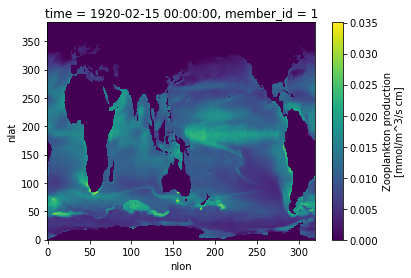

In [112]:
ds['zoo_prod'].isel(time=1,member_id=0).plot()

## Compute annual means 

In [113]:
%%time
ds_ann = util.ann_mean(ds, time_bnds_varname='time_bound', time_centered=True)
ds_ann

CPU times: user 18.4 s, sys: 803 ms, total: 19.2 s
Wall time: 19.3 s


,Array,Chunk
Bytes,5.63 GiB,0.94 MiB
Shape,"(181, 34, 384, 320)","(1, 1, 384, 320)"
Count,75525 Tasks,6154 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,5.63 GiB,0.94 MiB
Shape,"(181, 34, 384, 320)","(1, 1, 384, 320)"
Count,79319 Tasks,6154 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [114]:
# %%time

# for var in variables:
    
#     print('starting variable: ', var)
    
#     keep_vars = ['time_bound','TAREA','time','dz','KMT', 'member_id','TLAT','TLONG', var]

#     ds_out = ds_ann.drop([v for v in ds_ann.variables if v not in keep_vars])

#     outfile='/glade/scratch/kristenk/CESM-LE-output/CESM-LE-'+var+'.nc'
#     ds_out.to_netcdf(outfile)

In [115]:
# outfile='/glade/scratch/kristenk/CESM-LE-output/CESM-LE_fields_ann.nc'
# ds_ann.to_netcdf(outfile)

In [116]:
%%time
ds_djf = util.ann_mean(ds, season='DJF', time_bnds_varname='time_bound', time_centered=True)
ds_djf

CPU times: user 18.7 s, sys: 980 ms, total: 19.6 s
Wall time: 19.8 s


,Array,Chunk
Bytes,5.60 GiB,0.94 MiB
Shape,"(180, 34, 384, 320)","(1, 1, 384, 320)"
Count,90924 Tasks,6120 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,5.60 GiB,0.94 MiB
Shape,"(180, 34, 384, 320)","(1, 1, 384, 320)"
Count,94718 Tasks,6120 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [117]:
util.project_tmpdir

'/glade/scratch/kristenk/CESM-LE-output'

In [ ]:
%%time
dso_map = {
    f'{util.project_tmpdir}/cesm-le-fields-DJF.zarr': ds_djf.chunk({
        'time': -1, 
        'member_id': 1, 
        'nlat': -1, 
        'nlon': -1
    }
    ), 
    f'{util.project_tmpdir}/cesm-le-fields-ann.zarr': ds_ann.chunk({
        'time': -1, 
        'member_id': 1, 
        'nlat': -1, 
        'nlon': -1
    }
    ),     
}
for file_out, dso in dso_map.items():
    util.write_ds_out(dso, file_out)

------------------------------
Writing /glade/scratch/kristenk/CESM-LE-output/cesm-le-fields-DJF.zarr
xarray.Dataset {
dimensions:
	lat_aux_grid = 395 ;
	member_id = 34 ;
	moc_comp = 3 ;
	moc_z = 61 ;
	nlat = 384 ;
	nlon = 320 ;
	time = 180 ;
	transport_comp = 5 ;
	transport_reg = 2 ;
	z_t = 60 ;
	z_t_150m = 15 ;
	z_w = 60 ;
	z_w_bot = 60 ;
	z_w_top = 60 ;

variables:
	float64 ANGLE(nlat, nlon) ;
		ANGLE:long_name = angle grid makes with latitude line ;
		ANGLE:units = radians ;
	float64 ANGLET(nlat, nlon) ;
		ANGLET:long_name = angle grid makes with latitude line on T grid ;
		ANGLET:units = radians ;
	float64 DXT(nlat, nlon) ;
		DXT:long_name = x-spacing centered at T points ;
		DXT:units = centimeters ;
	float64 DXU(nlat, nlon) ;
		DXU:long_name = x-spacing centered at U points ;
		DXU:units = centimeters ;
	float64 DYT(nlat, nlon) ;
		DYT:long_name = y-spacing centered at T points ;
		DYT:units = centimeters ;
	float64 DYU(nlat, nlon) ;
		DYU:long_name = y-spacing centered at U poi

In [ ]:
ds_ann

### Add a variable for trophic transfer efficiency (TTE) ; fish catch at trophic levels 3 & 4
####  calculated as defined in Moore et al. (2018) SI

In [56]:
## create Ft grid
Ft = np.full((34, 181, 384, 320), 1, dtype=float)
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id'})
Ft=Ft.rename({'dim_1':'time'})
Ft=Ft.rename({'dim_2':'nlat'})
Ft=Ft.rename({'dim_3':'nlon'})

Ft_cold = Ft.where(ds_ann.TEMP_100m_mean < 20.)
Ft_warm =  Ft.where(ds_ann.TEMP_100m_mean >= 20.) * 0.74

In [57]:
#now convert everything to numpy arrays so we can merge the two grids
Ft = np.asarray(Ft)
Ft_cold = np.asarray(Ft_cold)
Ft_warm = np.asarray(Ft_warm)

Ft[~np.isnan(Ft_cold)] = Ft_cold[~np.isnan(Ft_cold)]
Ft[~np.isnan(Ft_warm)] = Ft_warm[~np.isnan(Ft_warm)]

#now put it back to an xarray
Ft = xr.DataArray(Ft)
Ft=Ft.rename({'dim_0':'member_id'})
Ft=Ft.rename({'dim_1':'time'})
Ft=Ft.rename({'dim_2':'nlat'})
Ft=Ft.rename({'dim_3':'nlon'})

ValueError: memoryview is too large

In [59]:
#trophic level 3
L = 3
alpha = 0.14
E = 0.14


f_T = 1
ds_ann['trophic_level3_prod_cold'] = alpha * ds_ann['zoo_prod'] * (f_T * E)**(L-2.1)
ds_ann.trophic_level3_prod_cold.attrs = ds_ann.zoo_prod.attrs
ds_ann.trophic_level3_prod_cold.attrs['long_name'] = 'trophic level 3 production'

In [45]:
def visualize_mask(mask3d):
    nregion = len(mask3d.region)

    # mask out land
    mask3d = mask3d.where(ds.KMT > 0)

    # visualize the regions
    ncol = int(np.sqrt(nregion))
    nrow = int(nregion / ncol) + min(1, nregion % ncol)

    fig, ax = plt.subplots(nrow, ncol, figsize=(4 * ncol, 3 * nrow), constrained_layout=True)

    for i, region in enumerate(mask3d.region.values):
        plt.axes(ax.ravel()[i])
        mask3d.sel(region=region).plot()

    # delete the unused axes
    for i in range(nregion, ncol * nrow):
        fig.delaxes(ax.ravel()[i])

    fig.suptitle(f'Mask name = {mask3d.mask_name}', fontsize=16)

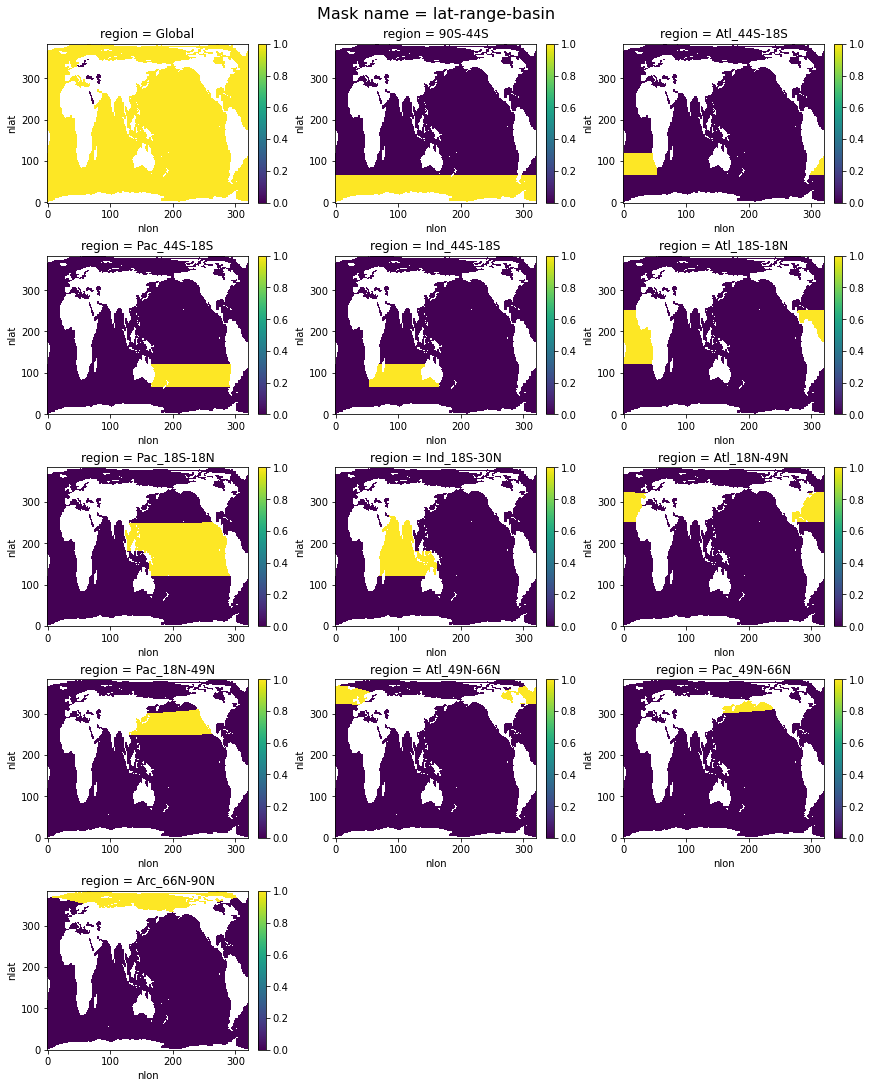

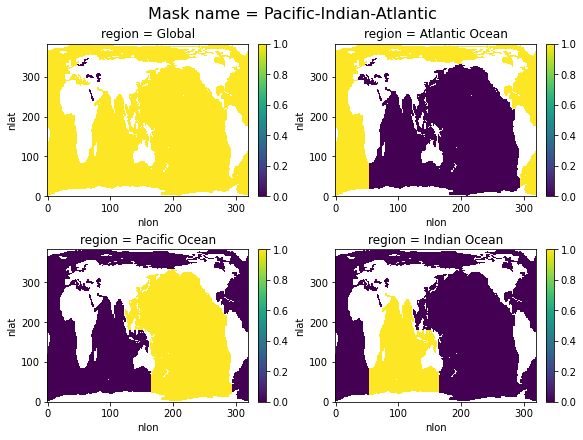

In [46]:
region_masks = pop_tools.list_region_masks('POP_gx1v6')
region_masks
for region_mask in region_masks:
    mask3d = pop_tools.region_mask_3d('POP_gx1v6', mask_name=region_mask)
    visualize_mask(mask3d)

In [60]:
ds_ann

,Array,Chunk
Bytes,5.63 GiB,0.94 MiB
Shape,"(181, 34, 384, 320)","(1, 1, 384, 320)"
Count,75525 Tasks,6154 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,5.63 GiB,0.94 MiB
Shape,"(181, 34, 384, 320)","(1, 1, 384, 320)"
Count,79319 Tasks,6154 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [63]:
region_masks

['lat-range-basin', 'Pacific-Indian-Atlantic']

In [64]:
mask3d = pop_tools.region_mask_3d('POP_gx1v6', mask_name='lat-range-basin')

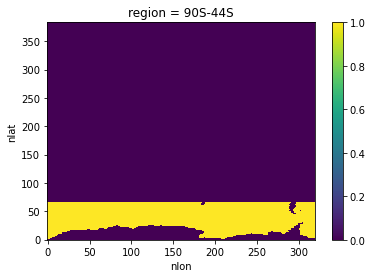

In [67]:
mask3d.isel(region=1).plot()

In [68]:
masked = TL3_prod_em1 * mask3d.isel(region=1)

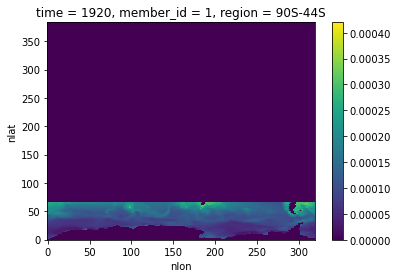

In [69]:
masked.isel(time=0).plot()

In [77]:
%%time

ts_SO = xr.Dataset({v: ds_ann[v] for v in ['time','member_id']})

masked = ds_ann.trophic_level3_prod_cold * mask3d.isel(region=1)

ts_SO['trophic_level3_prod_cold'] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

KilledWorker: ("('logical_not-9172b281f5cfc295a694fc3833754758', 0, 0, 0, 0)", <Worker 'tcp://10.12.206.63:42242', name: 1, memory: 0, processing: 632>)

distributed.core - ERROR - Exception while handling op heartbeat_worker
Traceback (most recent call last):
  File "/glade/work/kristenk/miniconda/envs/krill/lib/python3.7/site-packages/distributed/core.py", line 497, in handle_comm
    result = handler(comm, **msg)
  File "/glade/work/kristenk/miniconda/envs/krill/lib/python3.7/site-packages/distributed/scheduler.py", line 3648, in heartbeat_worker
    parent._tasks[key]: duration for key, duration in executing.items()
  File "/glade/work/kristenk/miniconda/envs/krill/lib/python3.7/site-packages/distributed/scheduler.py", line 3648, in <dictcomp>
    parent._tasks[key]: duration for key, duration in executing.items()
KeyError: "('open_dataset-089672e2c6542a4fc904536cfb6877f8graze_diaz-c8c44528e6f58afd5c8969953fea7afe', 24, 0, 0, 0)"


In [ ]:
ds_ann_ens_mean = ds_ann.mean(dim='member_id').compute()

try with just one ensemble member for now

In [79]:
%%time
TL3_prod_em1 = ds_ann.trophic_level3_prod_cold.isel(member_id=0)

ts_SO = xr.Dataset({v: ds_ann[v] for v in ['time']})

masked = TL3_prod_em1 * mask3d.isel(region=1)

ts_SO['trophic_level3_prod_cold'] = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

CPU times: user 14.9 s, sys: 1.21 s, total: 16.1 s
Wall time: 2min 39s


In [ ]:
masked = ds_ann_ens_mean * mask3d.isel(region=1)
ds_ann_ens_mean = esmlab.weighted_mean(masked, weights=grid.TAREA, dim=['nlat', 'nlon']).compute()

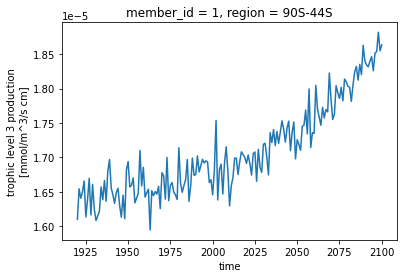

In [80]:
ts_SO['trophic_level3_prod_cold'].plot()

In [83]:
years = np.arange(1920,2101,1)

In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))
ax.set_title('TL3 production Southern Ocean')
ax.set_ylabel('TL3 production (mmol m$^{-2}$ d${-1}$)')

#for mem in np.arange(0,34,1):

ax.plot(years, ts_SO['trophic_level3_prod_cold'], 
     color='lightgray')

ax.plot(years, ds_ann_ens_mean, 
         color='black');

In [ ]:
style.use('default')
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(10,7))
ax.set_title('TL3 production Southern Ocean')
ax.set_ylabel('TL3 production (mmol m$^{-2}$ d${-1}$)')

#for mem in np.arange(0,34,1):

ax.plot(years, 
     ts_SO['trophic_level3_prod_cold'].isel(member_id=mem), 
     color='lightgray', label='TL3 production')

ax.plot(years, ts_lat_30S_45S_ens_mean, 
         color='black', label='zooplankton production');